<a href="https://colab.research.google.com/github/Collin-Campbell/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [ ]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Wrangle Data

## Import Data

In [ ]:
import pandas as pd

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')


Let's make a `wrangle` function

In [ ]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  return X

In [ ]:
train = wrangle(train)

# Split Data

## Split TV from FM

In [ ]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

# Training-Validation Split

- Randomized split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# Build Model(s)

- Missing values
- Categorical values

In [ ]:
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tree_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42) # <-- no need to scale
)

tree_model.fit(X_train, y_train);

In [ ]:
print('# of features before transformation:', X_train.shape[1])
XT_train = tree_model.named_steps['ordinalencoder'].transform(X_train)
print('# of features after transformation:', XT_train.shape[1])

# of features before transformation: 29
# of features after transformation: 29


# Check Metrics

In [ ]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9952650518739873
TREE: Validation Accuracy: 0.748989898989899


# Interlude I: How does a tree model work?

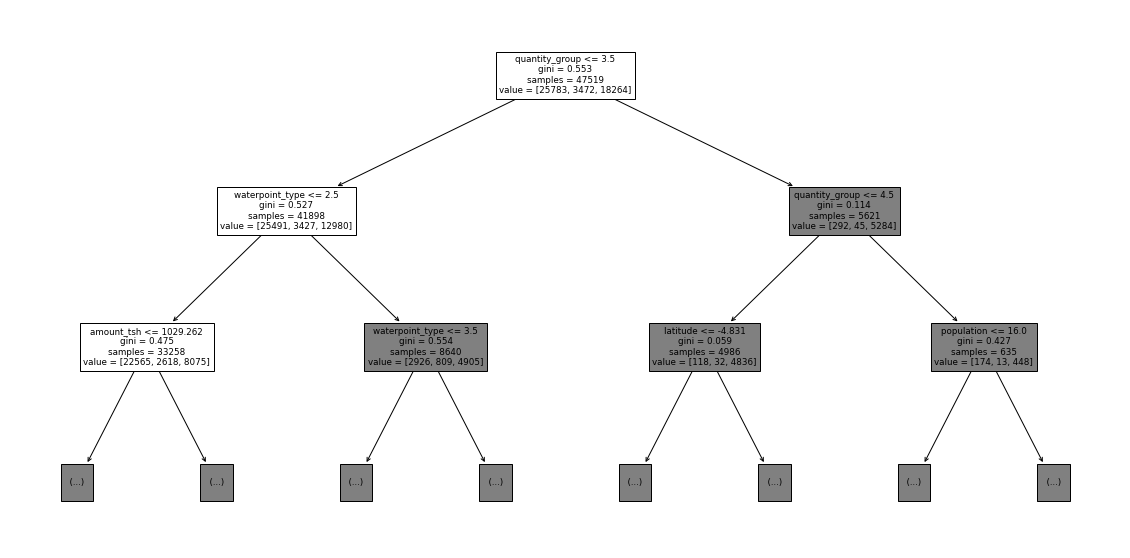

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.rcParams["figure.figsize"] = (20,10)

tree = tree_model.named_steps['decisiontreeclassifier']
plot_tree(tree, max_depth=2, feature_names=XT_train.columns);

# Interlude II: What is overfitting?

- `max_depth`

In [ ]:
depths = range(2,22,2)

train_acc = []
val_acc = []

# for depth in depths:
#   tree_model = make_pipeline(
#       OrdinalEncoder(),
#       SimpleImputer(),
#       DecisionTreeClassifier(max_depth=depth, random_state=42)
#   )

#   tree_model.fit(X_train, y_train)
#   train_acc.append(tree_model.score(X_train, y_train))
#   val_acc.append(tree_model.score(X_val, y_val))

# plt.plot(range(2,22,2), train_acc, label='training')
# plt.plot(range(2,22,2), val_acc, color='r', label='validation')
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend();

# Random Forests

- An example of **regularization**
- An example of an **ensemble method**
- An example of **bagging**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

train_acc = []
val_acc = []

for sample in np.arange(0.2, 1.0, 0.1):
  print('training model with max_samples:', sample)
  forest_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(n_estimators=20,
                            max_samples=sample,
                            random_state=42,
                            n_jobs=-1)
  )

  forest_model.fit(X_train, y_train)

  train_acc.append(forest_model.score(X_train, y_train))
  val_acc.append(forest_model.score(X_val, y_val))

training model with max_samples: 0.2
training model with max_samples: 0.30000000000000004
training model with max_samples: 0.4000000000000001
training model with max_samples: 0.5000000000000001
training model with max_samples: 0.6000000000000001
training model with max_samples: 0.7000000000000002
training model with max_samples: 0.8000000000000003
training model with max_samples: 0.9000000000000001


In [ ]:
print('FOREST: Training Accuracy:', forest_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', forest_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9659294177066016
FOREST: Validation Accuracy: 0.7851010101010101


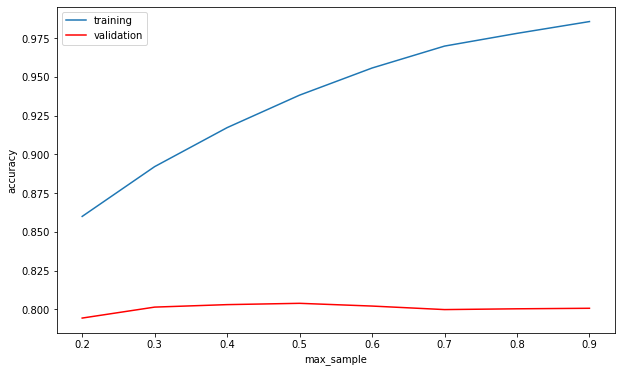

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(0.2, 1.0, 0.1), train_acc, label='training')
plt.plot(np.arange(0.2, 1.0, 0.1), val_acc, color='r', label='validation')
plt.xlabel('max_sample')
plt.ylabel('accuracy')
plt.legend();